Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    

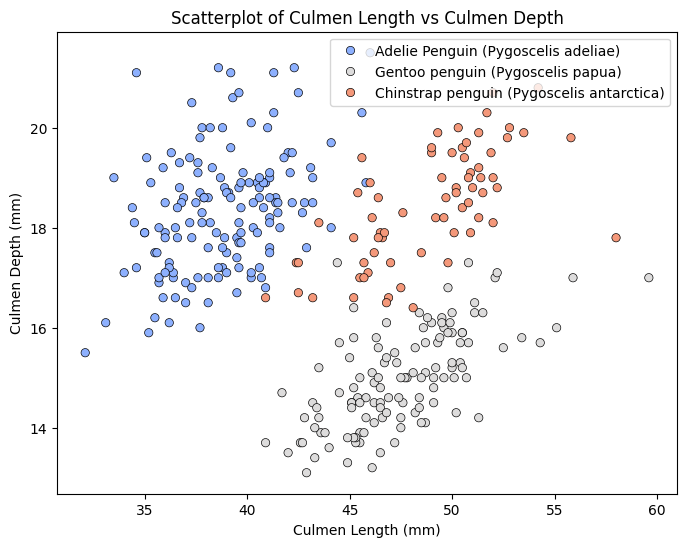

<Figure size 800x600 with 0 Axes>

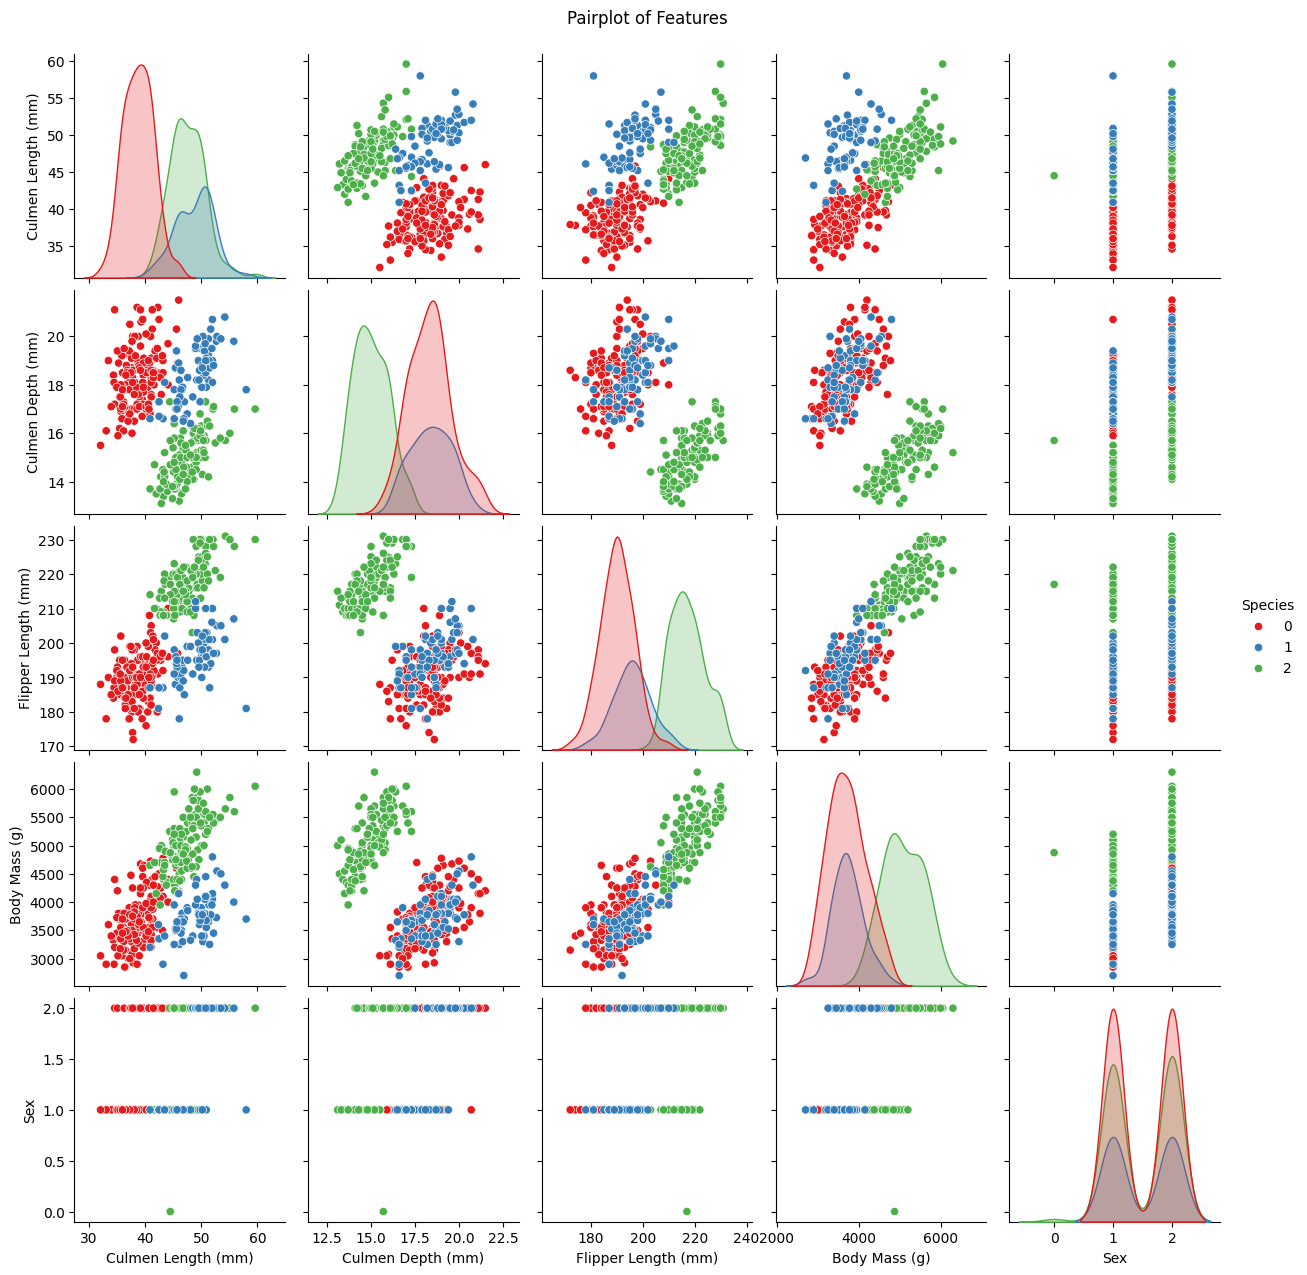

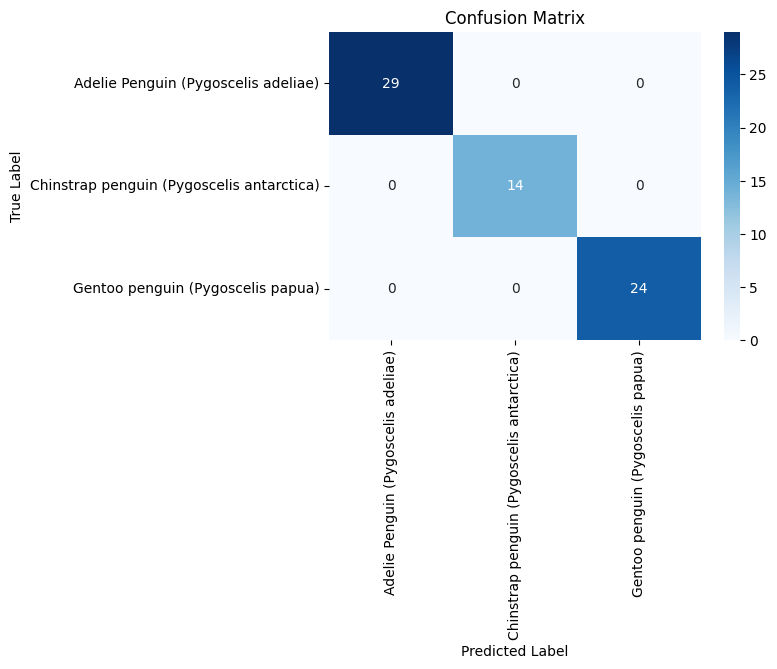

c:\Users\A.S.T.co\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


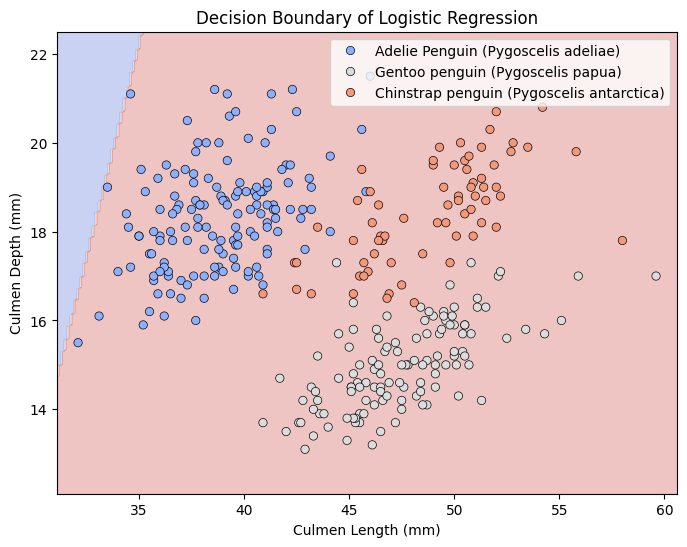

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# بارگذاری داده‌ها
file_path = "C:/Users/A.S.T.co/Downloads/penguins.csv"
penguins = pd.read_csv(file_path)

# نمایش اطلاعات اولیه داده‌ها
print("Initial Data Info:")
print(penguins.info())
print("Missing Values:\n", penguins.isnull().sum())

# انتخاب ویژگی‌ها و متغیر هدف
features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Sex"]
target_name = "Species"

# حذف داده‌های گم‌شده
penguins = penguins[features + [target_name]].dropna()

# تبدیل متغیر "Sex" به مقادیر عددی
encoder_sex = LabelEncoder()
penguins["Sex"] = encoder_sex.fit_transform(penguins["Sex"])

# تبدیل متغیر هدف به مقدار عددی
encoder_species = LabelEncoder()
penguins[target_name] = encoder_species.fit_transform(penguins[target_name])

# جداسازی ویژگی‌ها و برچسب‌ها
X = penguins[features]  
y = penguins[target_name]

# تقسیم داده‌ها به مجموعه آموزش و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# استانداردسازی داده‌ها
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# جستجوی شبکه‌ای برای یافتن بهترین هایپرپارامترها
param_grid = {"C": [0.01, 0.1, 1, 10, 100], "max_iter": [500, 1000, 1500]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# انتخاب بهترین مدل
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# پیش‌بینی روی داده‌های تست
y_pred = best_model.predict(X_test_scaled)

# نمایش دقت مدل
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# نمایش گزارش طبقه‌بندی
print("Classification Report:\n", classification_report(y_test, y_pred))

# رسم Scatterplot اولیه
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[features[0]], y=X[features[1]], hue=encoder_species.inverse_transform(y), palette="coolwarm", edgecolor="k")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title("Scatterplot of Culmen Length vs Culmen Depth")
plt.show()

# ---- اضافه کردن نمودارها ----

# نمودار plot از ویژگی‌ها
plt.figure(figsize=(8, 6))
sns.pairplot(penguins[features + [target_name]], hue=target_name, palette="Set1")
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()


# رسم ماتریس درهم‌ریختگی
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=encoder_species.classes_, yticklabels=encoder_species.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ====== رسم مرزهای تصمیم ======
def plot_decision_boundary(model, X, y, scaler):
    # فقط از دو ویژگی برای رسم مرز تصمیم استفاده می‌کنیم
    X_reduced = X.iloc[:, :2]  # استفاده از دو ویژگی اول (Culmen Length (mm), Culmen Depth (mm))
    
    # ایجاد مختصات برای رسم مرز تصمیم
    x_min, x_max = X_reduced.iloc[:, 0].min() - 1, X_reduced.iloc[:, 0].max() + 1
    y_min, y_max = X_reduced.iloc[:, 1].min() - 1, X_reduced.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # گسترش نقاط شبکه به 5 ویژگی برای استانداردسازی
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    # افزودن سه ویژگی دیگر به نقاط شبکه
    mesh_points_full = np.hstack([mesh_points, np.zeros((mesh_points.shape[0], 3))])

    # استانداردسازی نقاط شبکه
    mesh_points_scaled = scaler.transform(mesh_points_full)  
    Z = model.predict(mesh_points_scaled)
    Z = Z.reshape(xx.shape)

    # رسم مرز تصمیم
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    sns.scatterplot(x=X_reduced.iloc[:, 0], y=X_reduced.iloc[:, 1], hue=encoder_species.inverse_transform(y), palette="coolwarm", edgecolor="k")
    plt.xlabel(X_reduced.columns[0])
    plt.ylabel(X_reduced.columns[1])
    plt.title("Decision Boundary of Logistic Regression")
    plt.show()

# نمایش مرزهای تصمیم
plot_decision_boundary(best_model, X, y, scaler)
